We have a CSV file (that is read in a dataframe in the jupyter notebook) with timestamps in each row,  and the number of pedestrians observed in parts of a road network (in this case, locations in the Klaus courtyard). Time increases by one second each row. We aim to predict the number of pedestrians in the next timestamp, given k number of previous frames. 
Since this is a small demonstration, we can predict just one location. 

In [1]:
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
# Import pedestrian data
cadell524 = pd.read_csv("./ASPEDv1.1/5-24-Cadell-merged.csv")
print(cadell524.shape)

cadell524.head(10)

(160473, 26)


,timestamp,frame,recorder1_1m,recorder2_1m,recorder3_1m,recorder4_1m,recorder5_1m,recorder6_1m,recorder1_3m,recorder2_3m,...,recorder3_6m,recorder4_6m,recorder5_6m,recorder6_6m,recorder1_9m,recorder2_9m,recorder3_9m,recorder4_9m,recorder5_9m,recorder6_9m
0,05/24/2023 11:33:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,05/24/2023 11:33:01,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,05/24/2023 11:33:02,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,05/24/2023 11:33:03,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,05/24/2023 11:33:04,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,05/24/2023 11:33:05,5,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,05/24/2023 11:33:06,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,05/24/2023 11:33:07,7,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,1,0,0,0
8,05/24/2023 11:33:08,8,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
9,05/24/2023 11:33:09,9,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0


In [123]:
# Ensure the timestamp column is in datetime format
cadell524['timestamp'] = pd.to_datetime(cadell524['timestamp'])

# Filter out rows where time is not between 7 AM and 7 PM
cadell524 = cadell524[cadell524['timestamp'].dt.time.between(pd.to_datetime('07:00:00').time(), pd.to_datetime('19:00:00').time())]

In [100]:
cadell524.shape

(74075, 26)

# (1) Linear Regression Model

For simplicity, I tried predicting the number of person observed within the 6m boundary of Recorder 2.    
Target will then be cadell524['recorder2_6m'].

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [124]:
# number of previous frames to use for training
k = 5

# number of recorder locations at Klaus
num_locations = 6

In [125]:
# Dropping 1, 3, and 9m columns for simplicity.
del_cols = []

for loc in range(1, num_locations +1):
    for meter in ['1m', '3m', '6m']:
        del_cols.append(f'recorder{loc}_{meter}')

print(del_cols)

cadell524 = cadell524.drop(del_cols, axis=1)
cadell524.columns

['recorder1_1m', 'recorder1_3m', 'recorder1_6m', 'recorder2_1m', 'recorder2_3m', 'recorder2_6m', 'recorder3_1m', 'recorder3_3m', 'recorder3_6m', 'recorder4_1m', 'recorder4_3m', 'recorder4_6m', 'recorder5_1m', 'recorder5_3m', 'recorder5_6m', 'recorder6_1m', 'recorder6_3m', 'recorder6_6m']


Index(['timestamp', 'frame', 'recorder1_9m', 'recorder2_9m', 'recorder3_9m',
       'recorder4_9m', 'recorder5_9m', 'recorder6_9m'],
      dtype='object')

In [126]:
# Prepare the data with lagged features for each location
for loc in range(1, num_locations + 1):
    for i in range(1, k + 1):
        cadell524[f'recorder{loc}_lag{i}'] = cadell524[f'recorder{loc}_9m'].shift(i)


# Drop rows with NaN values - first k frames will be dropped because they will contrain NaN values in lags
cadell524 = cadell524.dropna()
cadell524.head()

,timestamp,frame,recorder1_9m,recorder2_9m,recorder3_9m,recorder4_9m,recorder5_9m,recorder6_9m,recorder1_lag1,recorder1_lag2,...,recorder5_lag1,recorder5_lag2,recorder5_lag3,recorder5_lag4,recorder5_lag5,recorder6_lag1,recorder6_lag2,recorder6_lag3,recorder6_lag4,recorder6_lag5
5,2023-05-24 11:33:05,5,1,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,2023-05-24 11:33:06,6,0,0,0,0,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2023-05-24 11:33:07,7,2,0,1,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2023-05-24 11:33:08,8,3,0,0,0,0,0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2023-05-24 11:33:09,9,3,0,0,0,0,0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# Split data
# Selecting target location for prediction
target = 'recorder2_9m' 

# Features (lagged values of all locations)
features = [f'recorder{loc}_lag{i}' for loc in range(1, num_locations + 1) for i in range(1, k + 1)]
X = cadell524[features]
y = cadell524[target]

X.head()

,recorder1_lag1,recorder1_lag2,recorder1_lag3,recorder1_lag4,recorder1_lag5,recorder2_lag1,recorder2_lag2,recorder2_lag3,recorder2_lag4,recorder2_lag5,...,recorder5_lag1,recorder5_lag2,recorder5_lag3,recorder5_lag4,recorder5_lag5,recorder6_lag1,recorder6_lag2,recorder6_lag3,recorder6_lag4,recorder6_lag5
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions, 
predictions = model.predict(X_test)

In [129]:
# and then round it to integer, since it is a pedestrian count
rounded_predictions = np.round(predictions).astype(int)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, rounded_predictions)
mse = mean_squared_error(y_test, rounded_predictions)
rmse = np.sqrt(mse)

# Custom accuracy: percentage of exactly correct predictions
accuracy = np.mean(y_test == rounded_predictions) * 100

# Print metrics
print("Predictions:", rounded_predictions)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

Predictions: [0 0 0 ... 0 0 0]
Mean Absolute Error (MAE): 0.07897934386391252
Mean Squared Error (MSE): 0.09437019036046983
Root Mean Squared Error (RMSE): 0.30719731502809366
Accuracy: 92.80%


In [94]:
feature_names = X_train.columns
coefficients_with_features = pd.DataFrame(zip(feature_names, model.coef_), columns=['Feature', 'Coefficient'])
print(coefficients_with_features)

           Feature  Coefficient
0   recorder1_lag1    -0.025055
1   recorder1_lag2    -0.001411
2   recorder1_lag3     0.007974
3   recorder1_lag4     0.008296
4   recorder1_lag5     0.015639
5   recorder2_lag1     0.699641
6   recorder2_lag2     0.148495
7   recorder2_lag3     0.023367
8   recorder2_lag4    -0.015606
9   recorder2_lag5    -0.012675
10  recorder3_lag1     0.006232
11  recorder3_lag2    -0.001133
12  recorder3_lag3    -0.000118
13  recorder3_lag4     0.004317
14  recorder3_lag5    -0.002527
15  recorder4_lag1     0.008577
16  recorder4_lag2     0.005831
17  recorder4_lag3    -0.013541
18  recorder4_lag4    -0.000836
19  recorder4_lag5     0.002658
20  recorder5_lag1    -0.050438
21  recorder5_lag2     0.065906
22  recorder5_lag3     0.036695
23  recorder5_lag4     0.040019
24  recorder5_lag5    -0.009379
25  recorder6_lag1    -0.006641
26  recorder6_lag2     0.002310
27  recorder6_lag3     0.004228
28  recorder6_lag4     0.002947
29  recorder6_lag5    -0.006735


In [79]:
import statsmodels.api as sm

# Assuming X_train and y_train are your training data
# Adding a constant to the model for the intercept
X_train_with_const = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_train_with_const).fit()

# Get the summary of the model
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:           recorder2_6m   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4689.
Date:                Wed, 24 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:12:24   Log-Likelihood:                 35111.
No. Observations:               61820   AIC:                        -7.016e+04
Df Residuals:                   61789   BIC:                        -6.988e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0025      0.001      4.

In [80]:
correlation_matrix = eprof2.corr()

# For Spearman
spearman_corr = eprof2.corr(method='spearman')

# For Kendall
kendall_corr = eprof2.corr(method='kendall')

correlation_matrix = eprof2.corr()

ax = sns.heatmap(
    correlation_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.show()


NameError: name 'eprof2' is not defined

## Visualize predicted counts

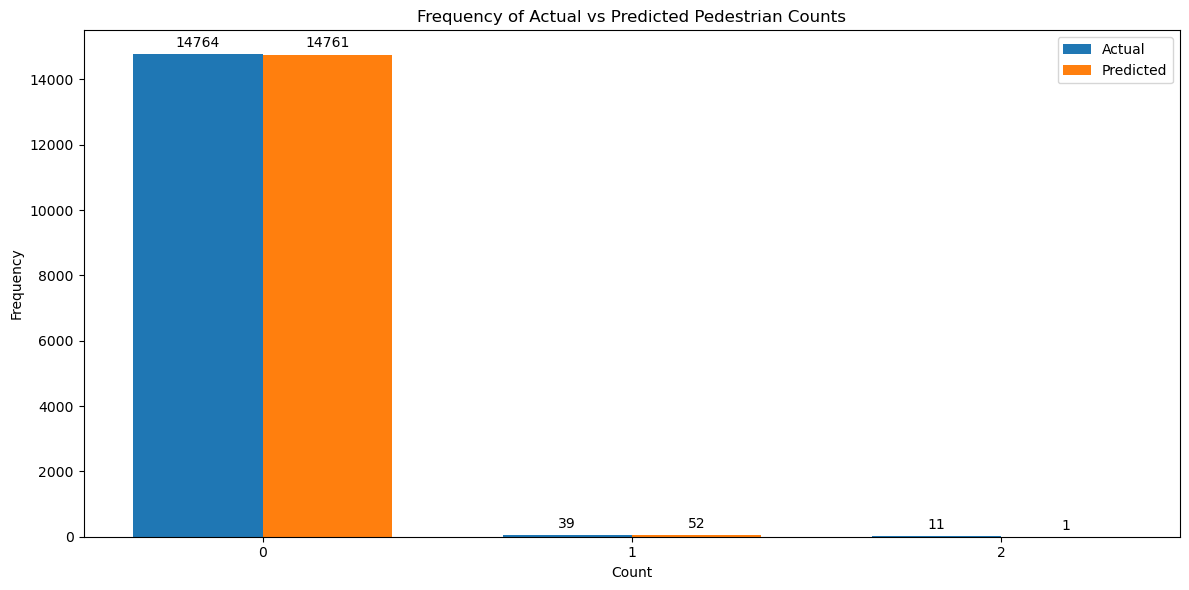

In [118]:
# Count frequencies for actual and predicted counts
actual_unique, actual_counts = np.unique(y_test, return_counts=True)
predicted_unique, predicted_counts = np.unique(rounded_predictions, return_counts=True)

actual_counts_dict = dict(zip(actual_unique, actual_counts))
predicted_counts_dict = dict(zip(predicted_unique, predicted_counts))

# Create a combined dictionary for all unique counts in both actual and predicted
all_unique_counts = set(actual_unique).union(set(predicted_unique))
combined_counts = {count: (actual_counts_dict.get(count, 0), predicted_counts_dict.get(count, 0)) for count in all_unique_counts}

# Separate the combined counts into two lists for plotting
actual_freq = [combined_counts[count][0] for count in all_unique_counts]
predicted_freq = [combined_counts[count][1] for count in all_unique_counts]

# Plotting
x = np.arange(len(all_unique_counts))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, actual_freq, width, label='Actual')
rects2 = ax.bar(x + width/2, predicted_freq, width, label='Predicted')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Actual vs Predicted Pedestrian Counts')
ax.set_xticks(x)
ax.set_xticklabels(all_unique_counts)
ax.legend()

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [119]:
from sklearn.metrics import accuracy_score

# Get unique counts
unique_counts = np.unique(y_test)

# Initialize a dictionary to hold accuracy for each count
accuracy_per_count = {}

for count in unique_counts:
    # Indices where the actual count is equal to the current count
    indices = np.where(y_test == count)

    # Actual and predicted values for these indices
    actual = y_test.iloc[indices]
    predicted = rounded_predictions[indices]

    # Calculate accuracy for this count
    accuracy = accuracy_score(actual, predicted)
    accuracy_per_count[count] = accuracy

# Print accuracy for each count
for count, accuracy in accuracy_per_count.items():
    print(f"Accuracy for count '{count}': {accuracy:.2f}")

Accuracy for count '0': 1.00
Accuracy for count '1': 0.54
Accuracy for count '2': 0.09


### Line chart of Model accuracy for each pedestrian count

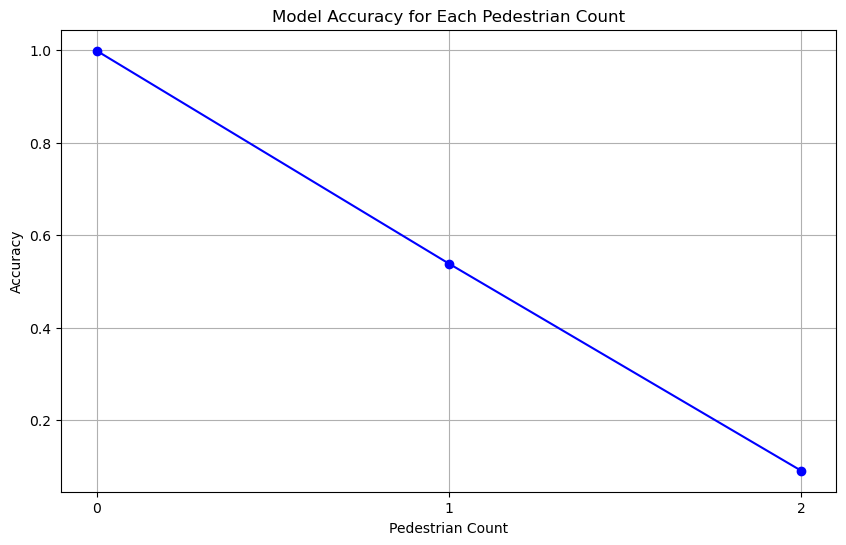

In [120]:
# Preparing data for the line chart
counts = list(accuracy_per_count.keys())
accuracies = list(accuracy_per_count.values())

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(counts, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy for Each Pedestrian Count')
plt.xlabel('Pedestrian Count')
plt.ylabel('Accuracy')
plt.xticks(counts)  # Ensure all counts are shown as x-ticks
plt.grid(True)
plt.show()

### Accuracy for non-zero predicted counts

In [130]:
# Filter out instances where the predicted count is non-zero
non_zero_predictions_indices = np.where(rounded_predictions > 0)
non_zero_actual = y_test.iloc[non_zero_predictions_indices]
non_zero_predicted = rounded_predictions[non_zero_predictions_indices]

# Calculate accuracy for non-zero predictions
accuracy_non_zero = accuracy_score(non_zero_actual, non_zero_predicted)
print(f"Accuracy for non-zero predicted counts: {accuracy_non_zero:.2f}")

Accuracy for non-zero predicted counts: 0.66


# (2) LSTM

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [50]:
# Import pedestrian data
cadell524_lstm = pd.read_csv("./ASPEDv1.1/5-24-Cadell-merged.csv")

# Ensure the timestamp column is in datetime format
cadell524_lstm['timestamp'] = pd.to_datetime(cadell524_lstm['timestamp'])

# Filter out rows where time is not between 7 AM and 7 PM
cadell524_lstm = cadell524_lstm[cadell524_lstm['timestamp'].dt.time.between(pd.to_datetime('07:00:00').time(), pd.to_datetime('19:00:00').time())]

# Dropping 1, 3, and 9m columns for simplicity.
del_cols = []

for loc in range(1, num_locations +1):
    for meter in ['1m', '3m', '9m']:
        del_cols.append(f'recorder{loc}_{meter}')

cadell524_lstm = cadell524_lstm.drop(del_cols, axis=1)

cadell524_lstm.head()

,timestamp,frame,recorder1_6m,recorder2_6m,recorder3_6m,recorder4_6m,recorder5_6m,recorder6_6m
0,2023-05-24 11:33:00,0,0,1,0,0,0,0
1,2023-05-24 11:33:01,1,0,0,0,0,0,0
2,2023-05-24 11:33:02,2,0,0,0,0,0,0
3,2023-05-24 11:33:03,3,0,0,0,0,0,0
4,2023-05-24 11:33:04,4,0,0,0,0,0,0


In [51]:
feature_columns = ['recorder1_6m', 'recorder2_6m', 'recorder3_6m', 'recorder4_6m', 'recorder5_6m']


# Normalize your features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(cadell524_lstm[feature_columns])

In [52]:
# Create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step)])
        y.append(data[i + time_step, 1])  # Predicting for 'loc1_count' as an example
    return np.array(X), np.array(y)

time_step = 5
X, y = create_dataset(scaled_data, time_step)

In [53]:
# Splitting dataset into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [54]:
# Creating the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

# Prediction
predictions = model.predict(X_test)
# Inverse transform the first feature ('loc1_count') if needed
# predictions = scaler.inverse_transform(predictions)

# Evaluation
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Epoch 1/100
926/926 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 2/100
926/926 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 3/100
926/926 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 4/100
926/926 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 5/100
926/926 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 6/100
926/926 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 7/100
926/926 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 8/100
926/926 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 9/100
926/926 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 10/100
926/926 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 11/100
926/926 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 12/100
926/926 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 13/100


In [55]:
# and then round it to integer, since it is a pedestrian count
rounded_predictions = np.round(predictions).astype(int)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, rounded_predictions)
mse = mean_squared_error(y_test, rounded_predictions)
rmse = np.sqrt(mse)

# Custom accuracy: percentage of exactly correct predictions
accuracy = np.mean(y_test == rounded_predictions) * 100

# Print metrics
print("Predictions:", rounded_predictions)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

Predictions: [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Mean Absolute Error (MAE): 0.015840871247918633
Mean Squared Error (MSE): 0.004695258239203157
Root Mean Squared Error (RMSE): 0.06852195443216107
Accuracy: 92.87%


In [56]:
from sklearn.metrics import accuracy_score

In [59]:
type(y_test)

numpy.ndarray

In [65]:
# Round predictions to the nearest integer and flatten
rounded_predictions = np.round(predictions).astype(int).flatten()
y_test_flattened = y_test.flatten()

# Filter to only non-zero predictions
non_zero_pred_indices = np.where(rounded_predictions > 0)[0]
non_zero_actual = y_test_flattened[non_zero_pred_indices]
non_zero_predicted = rounded_predictions[non_zero_pred_indices]

# Calculate the percentage of non-zero predictions that are exactly correct
correct_non_zero_predictions = non_zero_actual == non_zero_predicted
accuracy_non_zero = np.mean(correct_non_zero_predictions) * 100

print(f"Accuracy for correctly predicted non-zero counts: {accuracy_non_zero:.2f}%")

Accuracy for correctly predicted non-zero counts: 2.50%


In [68]:
y_test

array([0., 0., 0., ..., 0., 0., 0.])